In [107]:
import pandas as pd
import numpy as np
from pathlib import Path
import os 
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import log_loss,auc,classification_report,roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn import tree
import graphviz
import sklearn

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, manifold, ensemble, decomposition
from time import time

pd.set_option('display.max_columns', None)
%matplotlib inline
import sys
sys.path.append("..")
from ICM_utils import helper, evaluation, metrics
results_path = str(Path(os.getcwd()).parents[1]) + "/results/interpretability/"

In [ ]:
# Example of using ColumnTransformer
data = pd.DataFrame({'Name' : [3, 4,6], 'Age' : [18, 92,98], 'Weight' : [68, 59,49]})

col_names = ['Name', 'Age', 'Weight']
features = data[col_names]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('somename', StandardScaler(), ['Age', 'Weight'])
    ], remainder='passthrough')

ct.fit_transform(features)

In [108]:
import importlib
importlib.reload(evaluation)
importlib.reload(helper);
importlib.reload(sns);

## Missing Data Analysis

This package is a great way to visualize missing data, we can see here that Gene_Ihc_ATRX is missing from most of the observations for example. Below we have two ways to visualize the amount of missing data for each feature

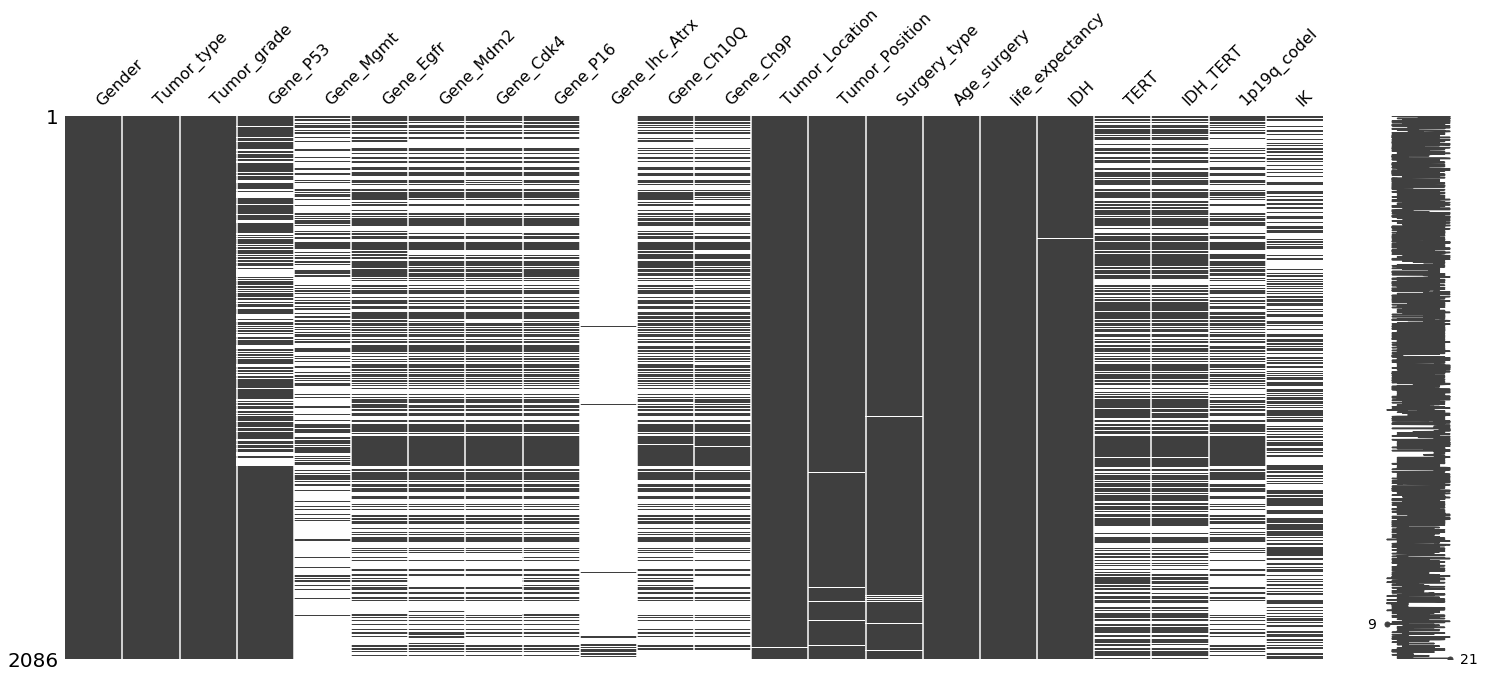

In [415]:
# Below missing data file 
PROCESSED_DATA_FILE = os.path.join(IMC_basedir, 'data/imputation_dataset_no_censoring_24022018.csv')

# Use missingno package to visualize missing data
df_md = pd.read_csv(PROCESSED_DATA_FILE)
import missingno as msno
fig = msno.matrix(df_md,inline=False);
plt.savefig(results_path + "missing_data_visualization")

In [ ]:
fig3 = msno.bar(df_md,inline=False,sort='descending')
plt.savefig(results_path + "null_counts_md")

**Heatmap of nullity correlations, a very important device to understand your pairwise missing data patterns:**
    
This can be useful for informing us of the missing data mechanism later
    1. -1 means that when one variable appears, the other definitely does not appear. 
    2. 0 means that variables have no influence on each other
    3. +1 means that when one variables appears, the other most definitely appears. 

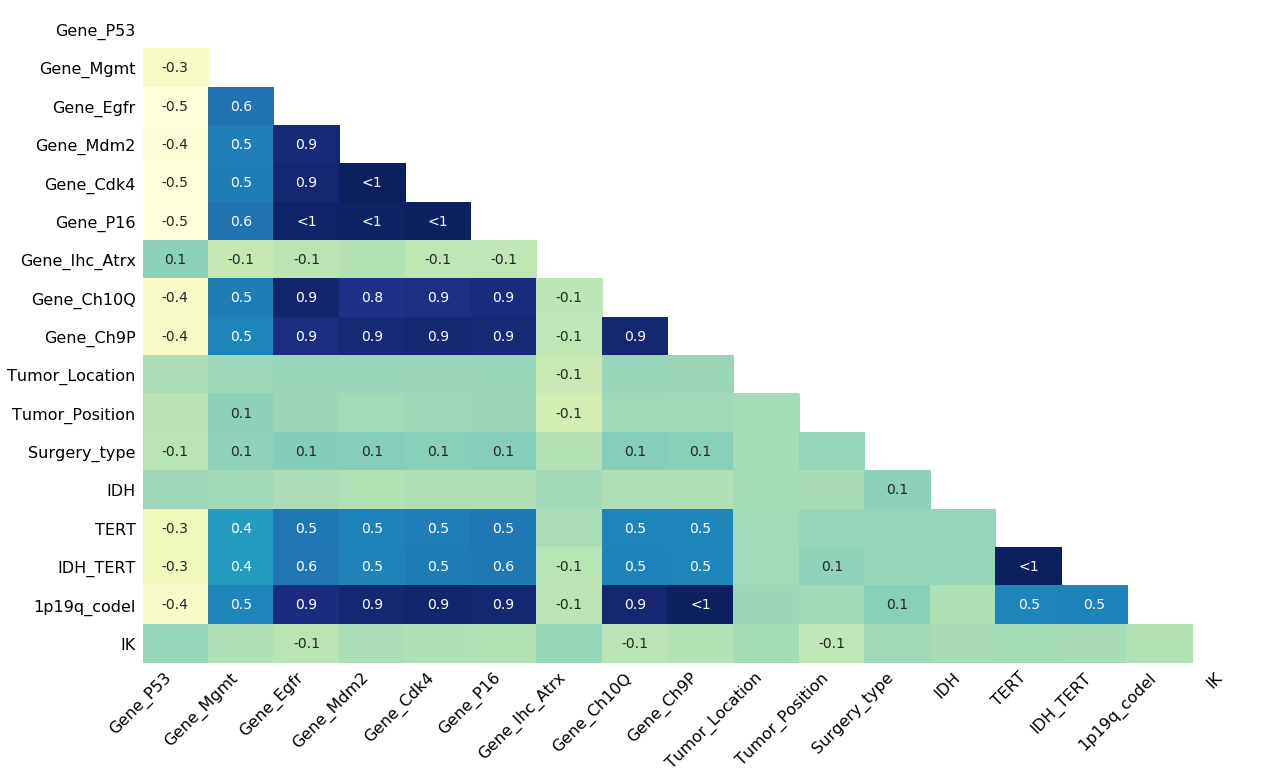

In [444]:
fig1 = msno.heatmap(df_md, inline=False,cmap="YlGnBu")
plt.savefig(results_path + "md_heatmap_correlations.eps",format='eps',dpi=1000)

Scipy dendogram outlining the correlations between certain variables. As seen before, the IDH_TERT and TERT appear together. 

In [ ]:
fig2 = msno.dendrogram(df_md,orientation='bottom', inline=False)
plt.savefig(results_path + "scipy_dendogram")

### TODO:  
    Data Exploration using dimensionality reduction techniques, i.e. TSNE 

In [ ]:
# Not currently working
tsne = manifold.TSNE(n_components=2,init='pca',random_state=0)

t0=time()
X_tsne = tsne.fit_transform(X)
helper.plot_embedding(X_tsne,"TSNE Embedding (time %.2fs)"%(time()-t0))

## 1. Amelia/MICE imputed dataset using no censoring (only patients with confirmed death)
* **Done**: GBM treatment is in a separate notebook
* **Done**: Understand what classes get confused
* Ongoing: Clinicians need interpretability if this is to be useful, see section 2 and GDocs
* Ongoing: Compare against Cox survival analysis model
* Ongoing: Explain why MICE over Amelia for our scenario

* Backlog: Run on missing dataset
* Backlog: TSNE visualization
* Backlog: Split the data into categories based on Alex's clustering 


## 2. IDEAS: 
* Plot predictor vs variables as pairplots and observe a few things. Reconcile them with Alex's exploration. Add all of them to the google doc.
    Observe how for tumor grade 4 the blue part is highly likely - you'll leave less then 1.5 years unfortunately. 
    Looking at life expectancy and age surgery we see no obvious relationship, other than it's slightly to the   left, so younger patients should live longer. 
* For IK it's the exact opposite, it seems that patients with IK will survive longer

## 3. Technicalities
* Categorical, no order - only used for visualization purposes
* Dummies
* Label Encoder is used only for visualization purposes, we use One-hot-encoding (dummies) for our analysis

In [109]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_Amelia_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')
DATA_CENSORING_MICE = os.path.join(IMC_basedir, 'data/imputed_dataset_with_censoring_26022018_MICE_original.csv')

Figure out the differences in datasets between censored and not censored

In [ ]:
df1 = pd.read_csv(DATA_CENSORING_MICE)

In [ ]:
df1.shape

In [122]:
labels = ["1.2 years","2.5years","more"]
cut_points = [400,900]

# Load the raw dataset
df = pd.read_csv(DATA_MICE_FILE)
# Rename this so that the from_dummies works and I don't have to spend another 60 min figuring out what to change. 
df.rename(columns={'Gene_Ihc_Atrx':'Gene_IhcAtrx'},inplace=True)

df_standardized = df.copy(deep=True)

col_names = ['Age_surgery', 'IK']
features = df_standardized[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df_standardized[col_names] = features


# Dummies dataset, used for analysis
df_dummies, labels = helper.process_dataset(df,labels,cut_points)
df_dummies_standardized, labels_standardized = helper.process_dataset(df_standardized, labels,cut_points)

# Label Encoded Dataset, used for visualization
df_encoded, le_dict = helper.label_encoder(df, labels, cut_points)

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


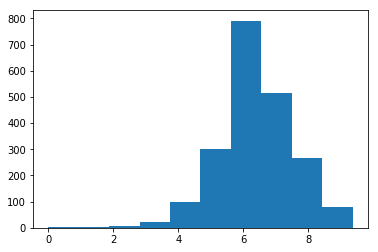

In [123]:
plt.hist(np.log(df_dummies.life_expectancy),bins =10);

In [ ]:
# This is life expectancy in days
life = df['life_expectancy'].values

# I think this is how you normalize data between with x_new = x - x.min()/(x.max() - x.min)
x_new = (life - life.mean())/life.std()
x_new

In [ ]:
sns.pairplot(data=df_dummies,vars=tuple(["IDH_TERT","TERT"]),hue='life_expectancy_bin',diag_kind='hist');
#hue='life_expectancy',height=3,kind='scatter')
#g = sns.pairplot(data=df_amelia,hue='life_expectancy_bin',size=3,kind='scatter')

In [ ]:
# Display all posibilities for dataframe
helper.display_values(df_dummies_standardized)

## Create training and validation/test (hold-out validation)

In [405]:
random_states = [1332, 1, 5 ,8, 100, 78]
X_train, Y_train, X_test, Y_test = helper.get_train_test_data(df_dummies,random_state=random_states[0])

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
X_train.head(2)

(1668, 53) (418, 53) (1668,) (418,)


/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Gender  Tumor_grade  Age_surgery  TERT  IDH_TERT  IK  \
1650       1            4           61     1         4  60   
397        1            3           34     0         3  70   

      Gene_Egfr_AMPLIFIE  Gene_Egfr_NORMAL  Gene_Mdm2_AMPLIFIE  \
1650                   1                 0                   0   
397                    0                 1                   0   

      Gene_Mdm2_NORMAL  Gene_Mgmt_METHYLE  Gene_Mgmt_NON METHYLE  \
1650                 1                  0                      1   
397                  1                  0                      1   

      X1p19q_codel_0  X1p19q_codel_1  Gene_IhcAtrx_Extinction diffuse  \
1650               1               0                                0   
397                1               0                                1   

      Gene_IhcAtrx_Maintien  Gene_IhcAtrx_extinction  Gene_P53_ALTERE  \
1650                      1                        0                0   
397                       0                        0                0   

      Gene_P53_NC  Gene_P53_NORMAL  Gene_Ch9P_GAIN  Gene_Ch9P_NON PERTE  \
1650            1                0               0                    0   
397             0                1               0                    1   

      Gene_Ch9P_PERTE  Tumor_type_GBM  Tumor_type_astrocytome  \
1650                1               1                       0   
397                 0               0                       0   

      Tumor_type_astrocytome gémistocytique (=A2)  \
1650                                            0   
397                                             0   

      Tumor_type_astrocytome pilocytique  Tumor_type_gangliogliome  \
1650                                   0                         0   
397                                    0                         0   

      Tumor_type_gliome  Tumor_type_oligo  Surgery_type_aucune  \
1650                  0                 0                    0   
397                   1                 0                    0   

      Surgery_type_biopsie  Surgery_type_exérèse  Surgery_type_partielle  \
1650                     1                     0                       0   
397                      0                     1                       0   

      IDH_NC  IDH_mutant  IDH_wt  Gene_Ch10Q_NON PERTE  Gene_Ch10Q_PERTE  \
1650       0           0       1                     0                 1   
397        0           1       0                     1                 0   

      Gene_Cdk4_AMPLIFIE  Gene_Cdk4_NORMAL  Tumor_Location_A  \
1650                   0                 1                 1   
397                    0                 1                 1   

      Tumor_Location_B  Tumor_Location_C  Tumor_Location_N  \
1650                 0                 0                 0   
397                  0                 0                 0   

      Tumor_Location_autre  Gene_P16_DELETE  Gene_P16_NORMAL  \
1650                     0                1                0   
397                      0                0                1   

      Tumor_Position_D  Tumor_Position_G  Tumor_Position_bilatéral  \
1650                 1                 0                         0   
397                  0                 1                         0   

      Tumor_Position_médian  Tumor_Position_non précisé  
1650                      0                           0  
397                       0                           0

In [125]:
X_train.describe(include=[np.number])

Gender  Tumor_grade  Age_surgery         TERT     IDH_TERT  \
count  1668.000000  1668.000000  1668.000000  1668.000000  1668.000000   
mean      0.619904     3.386091    54.202038     0.558153     3.330336   
std       0.485556     0.809866    15.282010     0.496756     0.727795   
min       0.000000     1.000000     8.000000     0.000000     2.000000   
25%       0.000000     3.000000    43.000000     0.000000     3.000000   
50%       1.000000     4.000000    55.000000     1.000000     3.000000   
75%       1.000000     4.000000    66.000000     1.000000     4.000000   
max       1.000000     4.000000    90.000000     1.000000     4.000000   

                IK  Gene_Egfr_AMPLIFIE  Gene_Egfr_NORMAL  Gene_Mdm2_AMPLIFIE  \
count  1668.000000         1668.000000       1668.000000         1668.000000   
mean     80.962230            0.338129          0.661871            0.226019   
std      11.862556            0.473215          0.473215            0.418377   
min      20.000000            0.000000          0.000000            0.000000   
25%      70.000000            0.000000          0.000000            0.000000   
50%      80.000000            0.000000          1.000000            0.000000   
75%      90.000000            1.000000          1.000000            0.000000   
max     100.000000            1.000000          1.000000            1.000000   

       Gene_Mdm2_NORMAL  Gene_Mgmt_METHYLE  Gene_Mgmt_NON METHYLE  \
count       1668.000000        1668.000000            1668.000000   
mean           0.773981           0.498201               0.501799   
std            0.418377           0.500147               0.500147   
min            0.000000           0.000000               0.000000   
25%            1.000000           0.000000               0.000000   
50%            1.000000           0.000000               1.000000   
75%            1.000000           1.000000               1.000000   
max            1.000000           1.000000               1.000000   

       X1p19q_codel_0  X1p19q_codel_1  Gene_IhcAtrx_Extinction diffuse  \
count     1668.000000     1668.000000                      1668.000000   
mean         0.871103        0.128897                         0.167266   
std          0.335186        0.335186                         0.373325   
min          0.000000        0.000000                         0.000000   
25%          1.000000        0.000000                         0.000000   
50%          1.000000        0.000000                         0.000000   
75%          1.000000        0.000000                         0.000000   
max          1.000000        1.000000                         1.000000   

       Gene_IhcAtrx_Maintien  Gene_IhcAtrx_extinction  Gene_P53_ALTERE  \
count            1668.000000              1668.000000      1668.000000   
mean                0.565947                 0.266787         0.067146   
std                 0.495781                 0.442413         0.250350   
min                 0.000000                 0.000000         0.000000   
25%                 0.000000                 0.000000         0.000000   
50%                 1.000000                 0.000000         0.000000   
75%                 1.000000                 1.000000         0.000000   
max                 1.000000                 1.000000         1.000000   

       Gene_P53_NC  Gene_P53_NORMAL  Gene_Ch9P_GAIN  Gene_Ch9P_NON PERTE  \
count  1668.000000      1668.000000     1668.000000          1668.000000   
mean      0.773381         0.159472        0.067746             0.507194   
std       0.418769         0.366226        0.251385             0.500098   
min       0.000000         0.000000        0.000000             0.000000   
25%       1.000000         0.000000        0.000000             0.000000   
50%       1.000000         0.000000        0.000000             1.000000   
75%       1.000000         0.000000        0.000000             1.000000   
max       1.000000         1.000000        1.000000         

## Logistic Regression Classifier

In [126]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

### Baseline Logistic Regression Classifier
    Takes 1-2 minutes to finish
    We see that we get a good loss and score with a simple model

Quantify uncertainties on the classification 

In [437]:
log_reg_acc = []
log_reg_log_loss = []

In [442]:
log_reg_log_loss

[0.6100478468899522, 0.6100478468899522]

In [443]:
l = np.array(labels)
base_lg = LogisticRegressionCV(Cs=100,penalty='l2',cv=5,multi_class='multinomial',random_state=random_states[2],max_iter=10000)
base_lg.fit(X_train,Y_train)
probas = base_lg.predict_proba(X_test)
error = log_loss(Y_test, probas)
print("For {0} class problem using base Logistic Regression --- Harsh Accuracy: {1} and Logloss: {2}".format(len(labels), base_lg.score(X_test,Y_test), error))

For 3 class problem using base Logistic Regression --- Harsh Accuracy: 0.6100478468899522 and Logloss: 0.8454740003373333


In [441]:
log_reg_acc.append(base_lg.score(X_test,Y_test))
log_reg_log_loss.append(error)

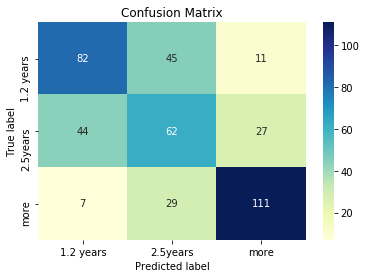

In [445]:
y_pred = base_lg.predict(X_test)
cm = evaluation.confusion_matrix(Y_test,y_pred,l)
evaluation.plot_confusion_matrix(cm,l,title="Confusion Matrix",cmap="YlGnBu")
plt.savefig(results_path+"multi_log_reg.eps",format='eps',dpi=1000)

Above is probably the best accuracy I can get with LogReg
**TODO: Try with normalized data as well**

In [ ]:
from concept_formation.datasets import load_mushroom
mushrooms = load_mushroom()

In [204]:
# As expected, this doesn't take into account the target variable. Reverts back to original categorical encoding
X_train_categorical = helper.from_dummies(X_train)
X_test_categorical = helper.from_dummies(X_test)

## Lime Interpretability Model 

In [205]:
import lime
import lime.lime_tabular

In [239]:
keys = le_dict.keys()

# Original column names and the class names, i.e. 1 year, 2 years etc. 
feature_names = X_train_categorical.columns.tolist()
class_names  = labels
categorical_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18]

In [ ]:
#### BELOW NOT USED - don't run
# For now, this must be a list of integers, I don't see why they couldn't make it a dictionary? 
categorical_names = {}
for feature in categorical_features:
    categorical_names[feature] = le_dict[X_train_categorical.columns[feature]].classes_

In [242]:
X_train.shape

(1668, 53)

In [207]:
# Need normal array for the next lines
X_train_encoded = np.asarray(X_train_categorical)
X_test_encoded = np.asarray(X_test_categorical)

In [208]:
categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le1 = LabelEncoder()
    le.fit(X_train_encoded[:, feature])
    le1.fit(X_test_encoded[:,feature])
    
    X_train_encoded[:, feature] = le.transform(X_train_encoded[:, feature])
    X_test_encoded[:, feature] = le1.transform(X_test_encoded[:, feature])
    categorical_names[feature] = le_dict[X_train_categorical.columns[feature]].classes_

In [209]:
categorical_names

{0: array(['AMPLIFIE', 'NORMAL'], dtype=object),
 1: array(['AMPLIFIE', 'NORMAL'], dtype=object),
 2: array(['METHYLE', 'NON METHYLE'], dtype=object),
 3: array([0, 1]),
 4: array(['Extinction diffuse', 'Maintien', 'extinction'], dtype=object),
 5: array(['ALTERE', 'NC', 'NORMAL'], dtype=object),
 6: array(['GAIN', 'NON PERTE', 'PERTE'], dtype=object),
 7: array(['GBM', 'astrocytome', 'astrocytome gémistocytique (=A2)',
        'astrocytome pilocytique', 'gangliogliome', 'gliome', 'oligo'],
       dtype=object),
 8: array(['aucune', 'biopsie', 'exérèse', 'partielle'], dtype=object),
 9: array(['NC', 'mutant', 'wt'], dtype=object),
 10: array(['NON PERTE', 'PERTE'], dtype=object),
 11: array(['AMPLIFIE', 'NORMAL'], dtype=object),
 12: array(['A', 'B', 'C', 'N', 'autre'], dtype=object),
 13: array(['DELETE', 'NORMAL'], dtype=object),
 14: array(['D', 'G', 'bilatéral', 'médian', 'non précisé'], dtype=object),
 15: array(['F', 'M'], dtype=object),
 18: array(['mutant', 'wt'], dtype=object)

### Rerun of Log Reg the SKLearn way 

In [210]:
data_train = X_train_encoded.astype(float)
data_test = X_test_encoded.astype(float)

In [266]:
encoder = OneHotEncoder(categorical_features=categorical_features)
encoder.fit(data_train)
encoded_train = encoder.transform(data_train)

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [396]:
l = np.array(labels)
base_lg = LogisticRegressionCV(Cs=100,penalty='l2',cv=5,multi_class='multinomial',random_state=random_states[1],max_iter=10000)
base_lg.fit(encoded_train,Y_train)
probas = base_lg.predict_proba(encoder.transform(data_test))
error = log_loss(Y_test, probas)
print("For {0} class problem using base Logistic Regression --- Harsh Accuracy: {1} and Logloss: {2}".format(len(labels), base_lg.score(encoder.transform(data_test),Y_test), error))

For 3 class problem using base Logistic Regression --- Harsh Accuracy: 0.6028708133971292 and Logloss: 0.8443737355766023


In [397]:
explainer = lime.lime_tabular.LimeTabularExplainer(data_train, class_names = class_names,
                feature_names= feature_names,
                categorical_features= categorical_features, 
                categorical_names = categorical_names,
                discretize_continuous=False)

In [398]:
predict_fn = lambda x: base_lg.predict_proba(encoder.transform(x)).astype(float)

In [316]:
# Top labels just means top classes 
i = np.random.randint(0, data_test.shape[0])
print(i)
print("True class: ",Y_test[i])
exp = explainer.explain_instance(data_test[i], predict_fn, num_features=5, top_labels=3)
base_lg.predict_proba(encoder.transform(data_test[i].reshape(1,-1)))

213
True class:  1.2 years


In [342]:
exp.show_in_notebook(show_table=True, show_all=False)

<Figure size 432x288 with 0 Axes>

In [330]:
# Top labels just means top classes 
i = np.random.randint(0, data_test.shape[0])
print(i)
print("True class: ",Y_test[i])
exp = explainer.explain_instance(data_test[i], predict_fn, num_features=5, top_labels=3)
base_lg.predict_proba(encoder.transform(data_test[i].reshape(1,-1)))

49
True class:  more


array([[0.03542781, 0.09794079, 0.8666314 ]])

In [331]:
exp.show_in_notebook(show_table=True, show_all=False)

In [399]:
# Top labels just means top classes 
#i = np.random.randint(0, data_test.shape[0])
i = 3
print("True class: ",Y_test[i])
exp = explainer.explain_instance(data_test[i], predict_fn, num_features=5, top_labels=3)
base_lg.predict_proba(encoder.transform(data_test[i].reshape(1,-1)))

True class:  1.2 years


array([[0.10799221, 0.21638885, 0.67561894]])

In [382]:
X_test_categorical.iloc[[6]]

Gene_Egfr Gene_Mdm2 Gene_Mgmt X1p19q_codel Gene_IhcAtrx Gene_P53  Gene_Ch9P  \
6    NORMAL  AMPLIFIE   METHYLE            1   extinction       NC  NON PERTE   

  Tumor_type Surgery_type IDH Gene_Ch10Q Gene_Cdk4 Tumor_Location Gene_P16  \
6      oligo      biopsie  NC  NON PERTE  AMPLIFIE              A   NORMAL   

  Tumor_Position  Gender  Tumor_grade  Age_surgery  TERT  IDH_TERT  IK  
6    non précisé       1            3           35     1         2  70

In [447]:
exp.show_in_notebook(show_table=True, show_all=False)

# Random Forest
* **Done**: Data standardization for the continuous variables - it's not necessary in this case.
* **Done**: Do Cross Validation with KFold
* **Done**: Random Forests
* **Done**: Tune learning rate? Tune max_depth? This was done by Paul
* **Done**: * Wide and Deep NN with Tensorflow - done in a separate notebook

* Backlog: AUC adapted for 3 classes needs to be double checked. Meanwhile, just use the confusion matrix

### Baseline Random Forest Classifier 

In [26]:
l = np.array(labels)
base_rfc = RandomForestClassifier(n_estimators = 500, random_state=1233)
base_rfc.fit(X_train, Y_train)
probas = base_rfc.predict_proba(X_test)
#y_pred_probas = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem using base Random Forest --- Harsh Accuracy: {1} and Logloss: {2}".format(len(labels), base_rfc.score(X_test,Y_test), error))

For 3 class problem using base Random Forest --- Harsh Accuracy: 0.5956937799043063 and Logloss: 0.8817143549792303


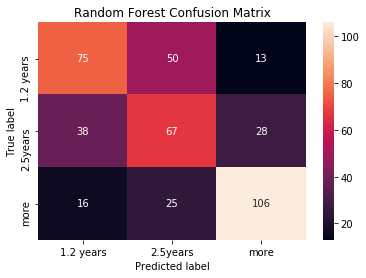

In [15]:
y_pred = base_rfc.predict(X_test)
cm = evaluation.confusion_matrix(Y_test,y_pred,l)
evaluation.plot_confusion_matrix(cm,l,"Random Forest Confusion Matrix")

### Grid Search - 1h20min

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Create a model with 400 estimators for the grid search
rfc = RandomForestClassifier(random_state = 1233)


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    "criterion": ["gini", "entropy"],
    "n_estimators": [10,20,50,100,300,500,1000,1500]
}
#"max_features": ['auto','log2']


# Instantiate GRID SEARCH over the space of parameters defined 
grid_search = GridSearchCV(estimator = rfc, param_grid=param_grid, 
                           n_jobs = -1, verbose = 2,
                           scoring='neg_log_loss', cv = 5, return_train_score=True)

# Fit the model - should not show processing 
grid_search.fit(X_train, Y_train);

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 46.7min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

In [18]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [19]:
best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels)
best_grid

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=80, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=1233, verbose=0, warm_start=False)

In [ ]:
# Compare to previous approach - I don't think this one is better (Fix helper)
#df = pd.DataFrame.from_dict(grid_search.cv_results_) 
#helper.write_to_pickle(df,"RandomForest_CV_400estimators")

              precision    recall  f1-score   support

   1.2 years       0.60      0.59      0.59       138
    2.5years       0.46      0.45      0.45       133
        more       0.73      0.75      0.74       147

   micro avg       0.60      0.60      0.60       418
   macro avg       0.59      0.60      0.59       418
weighted avg       0.60      0.60      0.60       418

Accuracy: 0.6004784688995215
For 3 class problem using BEST RF Model --- Harsh Accuracy: 0.6004784688995215 and Logloss: 0.8529229867230415


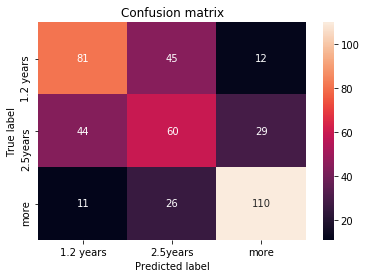

In [42]:
rfc=RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=80, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=1233, verbose=0, warm_start=False)

rfc.fit(X_train, Y_train)

# Accuracy on test
accuracy = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

# Plot Report
evaluation.plot_report(Y_test, l[y_pred], labels)
print("For {0} class problem using BEST RF Model --- Harsh Accuracy: {1} and Logloss: {2}".format(len(labels), accuracy, error))    

In [42]:
y_pred = rfc.predict(X_test)

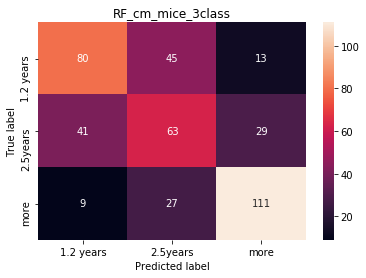

In [43]:
plt.figure()
evaluation.plot_confusion_matrix(confusion_matrix(Y_test, y_pred),
                          classes=labels, title='RF_cm_mice_3class')
plt.savefig(results_path+"RF_CM_MICE_3CLASS_GRIDSEARCH")

## Inspect confusion points
  * Here we are interested in what features the confused predictions had. For example, we look at the 9 patients in the corner that the prediction wrongly predicted to survive 1.2 years whereas they survived more than 3 years. We observe that age at surgery is between 60-64 with one at 39 and all of them had GBM type tumours. This is quite indicative of the fact that GBM and age are strong indicators of shorter lifespan. We investigate further into these features

In [383]:
confused12 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[0],labels[1])
confused1more = evaluation.confused_entries(X_test,Y_test,y_pred,labels[0],labels[2])

confused21 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[1],labels[0])
confused2more = evaluation.confused_entries(X_test,Y_test,y_pred,labels[1],labels[2])

confusedmore1 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[2],labels[0])
confusedmore2 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[2],labels[1])

In [384]:
confused1more

Gender  Tumor_grade  Age_surgery  TERT  IDH_TERT  IK  \
1009       1            3           34     0         3  80   
1315       1            3           35     1         2  70   
1101       1            3           49     1         4  90   
1159       1            3           44     1         4  90   
56         1            3           61     0         3  90   
541        0            3           46     1         2  60   
85         1            3           58     1         2  80   
1024       0            3           48     1         4  80   
634        1            4           40     1         4  90   
746        1            2           66     0         3  90   
395        1            4           46     0         2  90   

      Gene_Egfr_AMPLIFIE  Gene_Egfr_NORMAL  Gene_Mdm2_AMPLIFIE  \
1009                   0                 1                   0   
1315                   0                 1                   1   
1101                   1                 0                   0   
1159                   0                 1                   0   
56                     0                 1                   0   
541                    1                 0                   1   
85                     1                 0                   0   
1024                   1                 0                   0   
634                    0                 1                   0   
746                    0                 1                   1   
395                    0                 1                   0   

      Gene_Mdm2_NORMAL  Gene_Mgmt_METHYLE  Gene_Mgmt_NON METHYLE  \
1009                 1                  1                      0   
1315                 0                  1                      0   
1101                 1                  0                      1   
1159                 1                  1                      0   
56                   1                  0                      1   
541                  0                  1                      0   
85                   1                  1                      0   
1024                 1                  1                      0   
634                  1                  0                      1   
746                  0                  1                      0   
395                  1                  1                      0   

      X1p19q_codel_0  X1p19q_codel_1  Gene_IhcAtrx_Extinction diffuse  \
1009               1               0                                1   
1315               0               1                                0   
1101               1               0                                1   
1159               1               0                                0   
56                 0               1                                0   
541                0               1                                0   
85                 1               0                                1   
1024               1               0                                1   
634                1               0                                0   
746                1               0                                0   
395                1               0                                0   

      Gene_IhcAtrx_Maintien  Gene_IhcAtrx_extinction  Gene_P53_ALTERE  \
1009                      0                        0                0   
1315                      0                        1                0   
1101                      0                        0                0   
1159                      0                        1                0   
56                        0                        1                0   
541                       1                        0                0   
85                        0                        0                0   
1024                      0                        0                0   
634                       0                        1                0   
746                       0                 

In [388]:
confused = helper.from_dummies(confused1more)

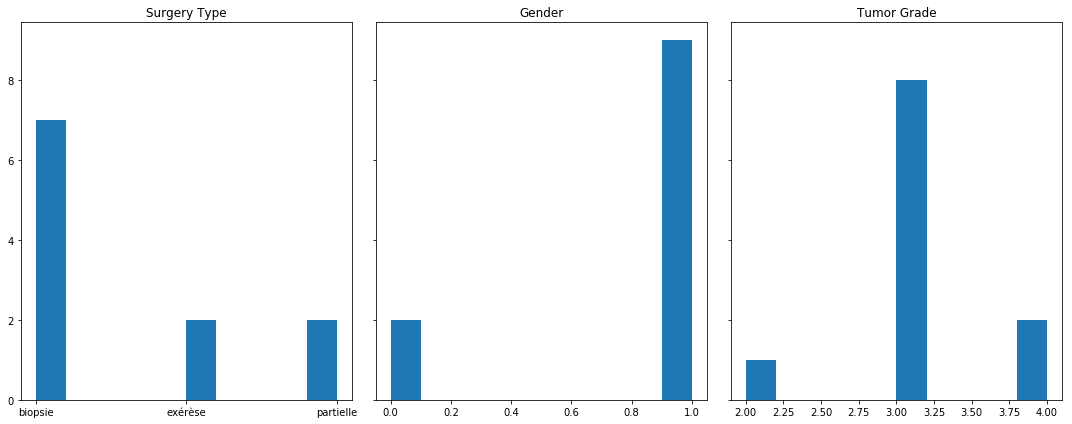

In [446]:
fig, axes = plt.subplots(1, 3, figsize=(15,6),sharey=True, sharex=False)
#ax.set_xlabel("GBM Tumor Type")
#ax.set_ylabel("Count")
#ax[0].hist(confused21.Tumor_type_GBM)
axes[0].hist([confused.Surgery_type])
axes[0].set_title('Surgery Type')


axes[1].hist([confused.Gender])
axes[1].set_title('Gender')


axes[2].hist([confused.Tumor_grade])
axes[2].set_title('Tumor Grade')


fig.tight_layout()
fig.savefig(results_path + "gbm_misclassified.eps",format='eps',dpi=1000)

Another analysis of confused predictions and patients tumor types. Somewhat expected is that the algorithm missclassifies patients within the 1.2 and 2.5 years span that have GBM tumours. 

In [47]:
# Reconstruct the dataframes as in the beginning
cf12 = helper.from_dummies(confused12)
cf1more = helper.from_dummies(confused1more)

cf21 = helper.from_dummies(confused21)
cf2more = helper.from_dummies(confused2more)

cfmore1 = helper.from_dummies(confusedmore1)
cfmore2 = helper.from_dummies(confusedmore2)

In [48]:
cfmore1

Gene_P53 IDH Gene_Cdk4 Gene_Ch10Q Tumor_Location X1p19q_codel Gene_P16  \
0       NC  wt    NORMAL      PERTE              N            0   NORMAL   
1       NC  wt    NORMAL  NON PERTE              B            0   DELETE   
2       NC  wt    NORMAL      PERTE              A            0   DELETE   
3       NC  wt    NORMAL      PERTE              A            0   NORMAL   
4       NC  wt    NORMAL      PERTE              A            0   DELETE   
5       NC  wt    NORMAL  NON PERTE              A            0   DELETE   
6       NC  wt  AMPLIFIE      PERTE              A            0   NORMAL   
7   NORMAL  wt    NORMAL  NON PERTE              A            0   NORMAL   
8       NC  wt    NORMAL      PERTE              A            0   NORMAL   

   Gene_Ch9P Gene_Egfr Gene_Mdm2    Gene_Mgmt    Gene_Ihc Tumor_type  \
0      PERTE  AMPLIFIE    NORMAL      METHYLE    Maintien        GBM   
1  NON PERTE    NORMAL    NORMAL  NON METHYLE  extinction        GBM   
2  NON PERTE    NORMAL    NORMAL  NON METHYLE    Maintien        GBM   
3      PERTE  AMPLIFIE    NORMAL  NON METHYLE    Maintien        GBM   
4      PERTE  AMPLIFIE    NORMAL  NON METHYLE    Maintien        GBM   
5      PERTE  AMPLIFIE    NORMAL  NON METHYLE    Maintien        GBM   
6      PERTE    NORMAL  AMPLIFIE  NON METHYLE    Maintien        GBM   
7  NON PERTE    NORMAL    NORMAL      METHYLE    Maintien        GBM   
8      PERTE    NORMAL    NORMAL  NON METHYLE    Maintien        GBM   

  Surgery_type Tumor_Position  Gender  Tumor_grade  Age_surgery  TERT  \
0    partielle              D       0            4           63     0   
1       aucune    non précisé       1            4           39     0   
2      exérèse              D       1            4           60     0   
3    partielle              D       0            4           64     0   
4      biopsie              D       0            4           64     1   
5    partielle              G       1            4           64     1   
6      biopsie              G       0            4           62     0   
7      exérèse              D       0            4           62     1   
8      biopsie              G       0            4           61     1   

   IDH_TERT   IK  
0         3   90  
1         3   70  
2         3   70  
3         3   80  
4         4   90  
5         4  100  
6         3   80  
7         4   70  
8         4   70

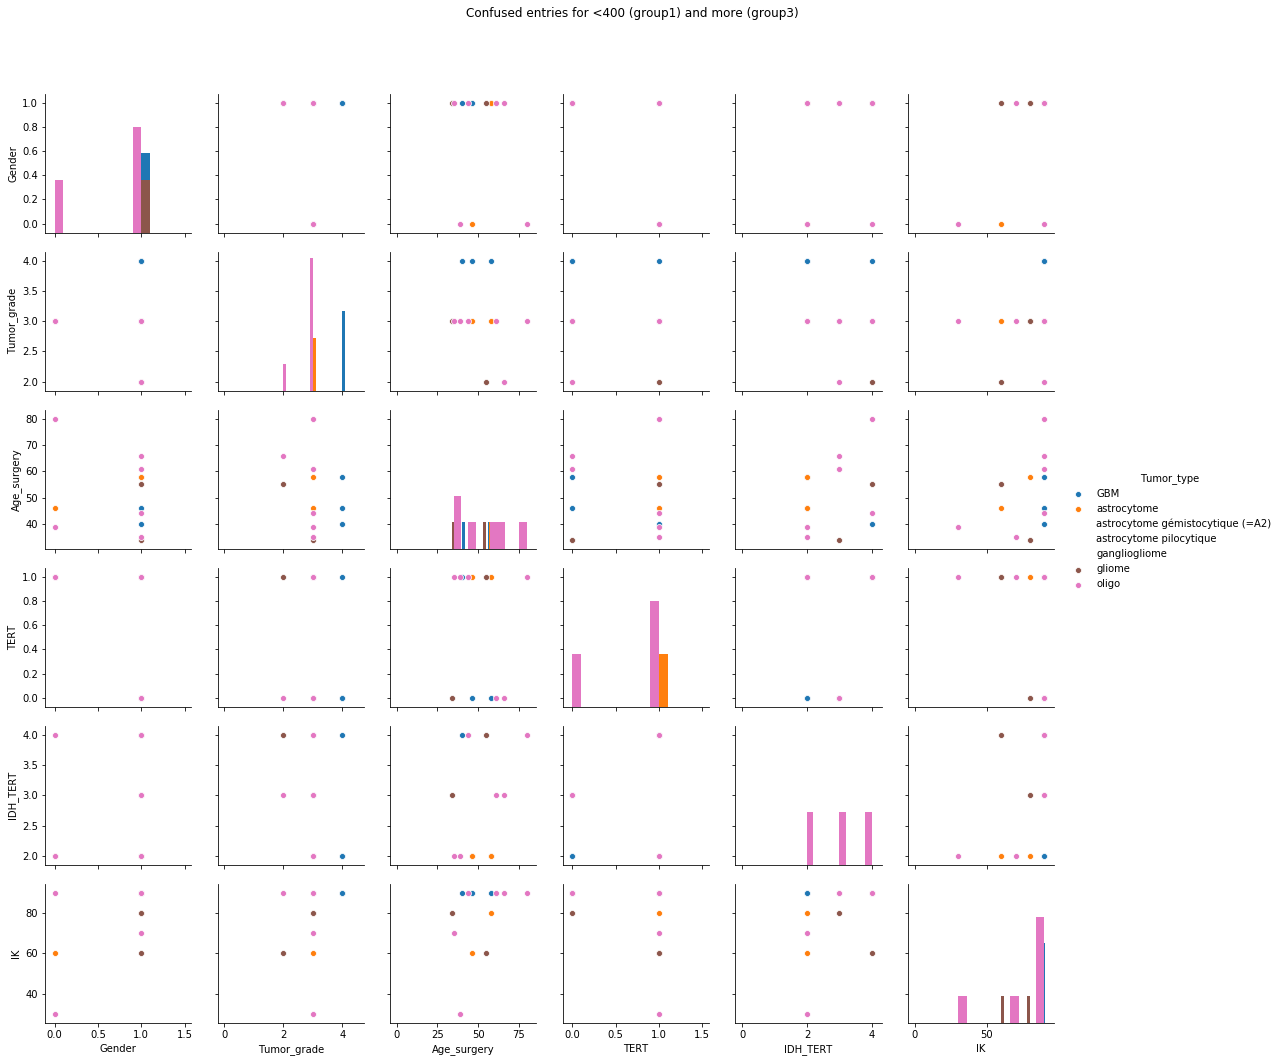

In [71]:
# Pairplot some of the variables
g1 = sns.pairplot(data=cf1more,hue='Tumor_type',vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],diag_kind='hist')
plt.subplots_adjust(top=0.9)
g1.fig.suptitle('Confused entries for <400 (group1) and more (group3)') 
g1.savefig(results_path + "1st-2nd Group GBM confused patients")

**Something happened in the pairplot method, please don't run this before is fixed to not replot wrongly as above**

Text(0.5,0.98,'Confused entries for <400 (group1) and <900 (group2)')

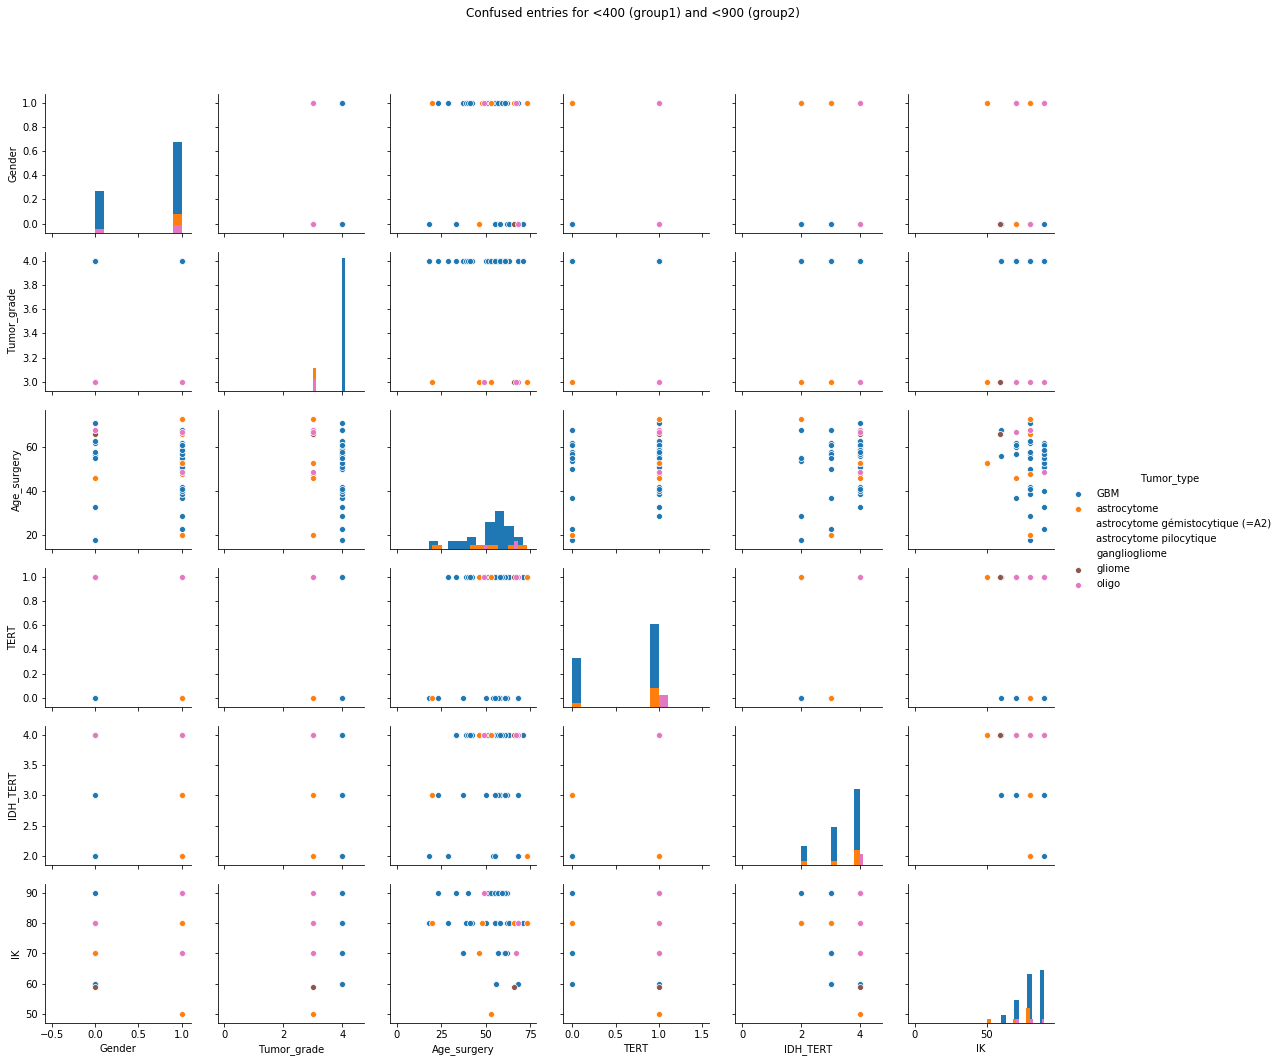

In [61]:
g2 = sns.pairplot(data=cf12,hue="Tumor_type",diag_kind='hist',vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"])
plt.subplots_adjust(top=0.9)
g2.fig.suptitle('Confused entries for <400 (group1) and <900 (group2)') 
#g2.savefig(results_path + "1st-3rd Group GBM confused patients")

Below we can see joint plots between the two groups based on various categories and the type of tumours present. We see that GBM is strongly present in most places where the algorithm got confused

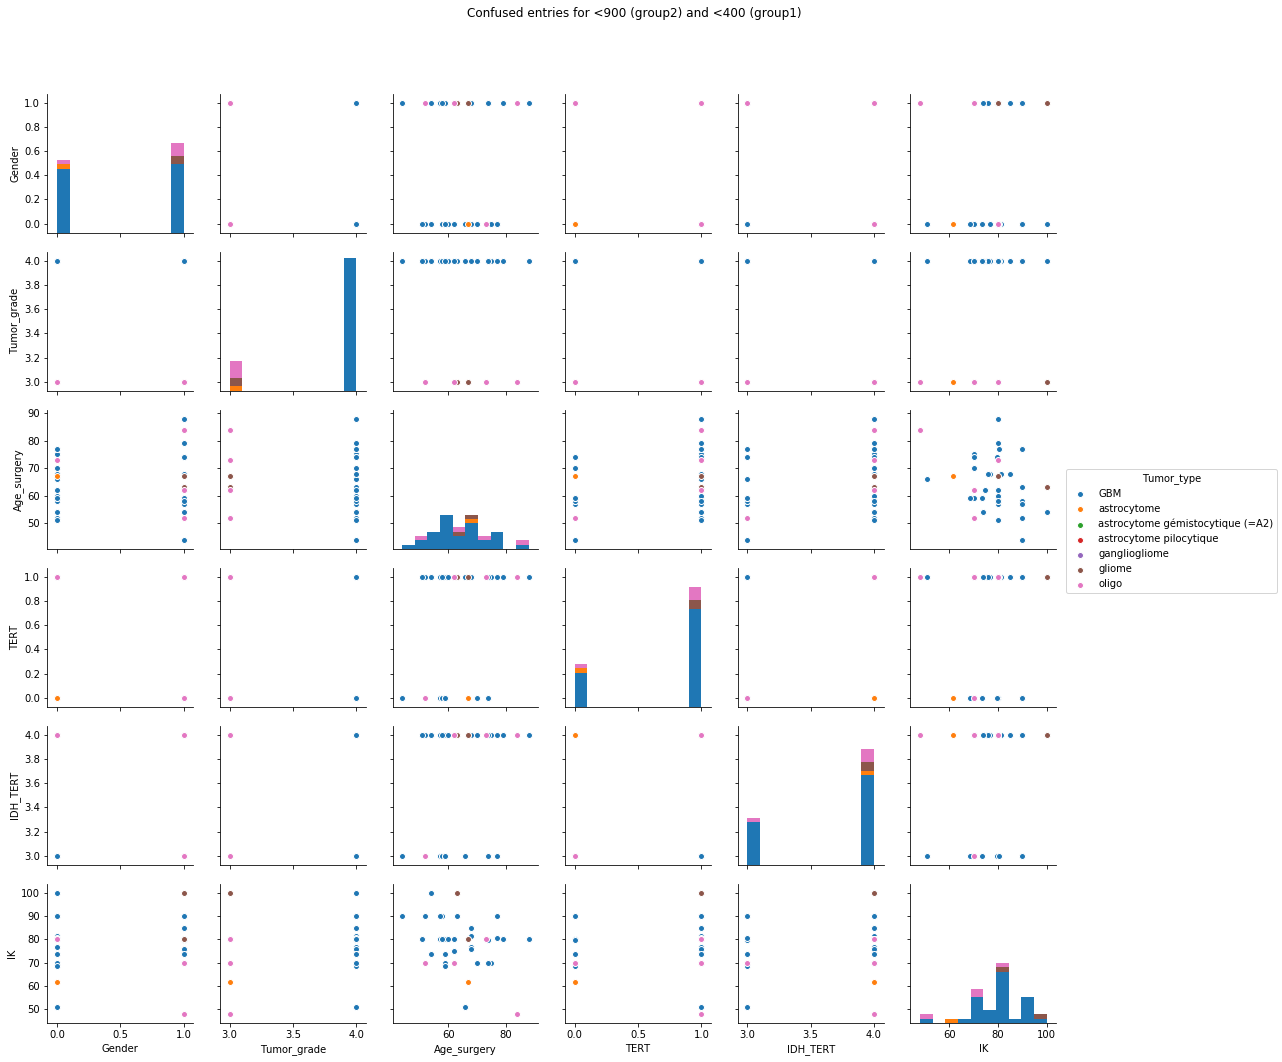

In [63]:
g3 = sns.pairplot(data=cf21,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g3.fig.suptitle('Confused entries for <900 (group2) and <400 (group1)') 
g3.savefig(results_path + "2st-1rd Group GBM confused patients")

Text(0.5,0.98,'Confused entries for <900 (group2) and more (group3)')

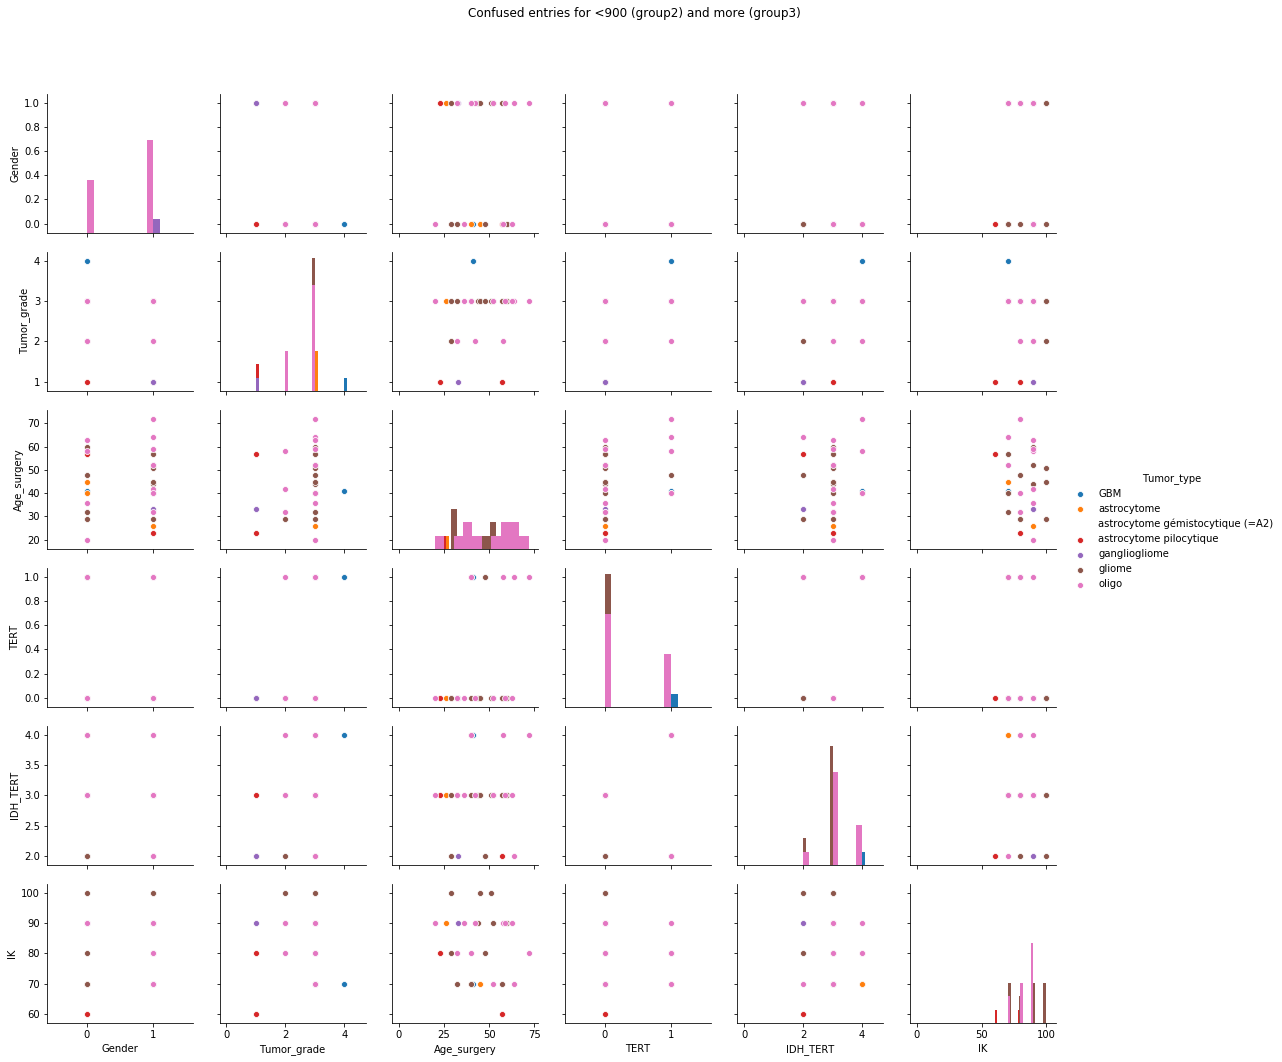

In [72]:
g4 = sns.pairplot(data=cf2more,hue="Tumor_type",vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],diag_kind='hist');
plt.subplots_adjust(top=0.9)
g4.fig.suptitle('Confused entries for <900 (group2) and more (group3)') 
#g4.savefig(results_path + "2st-3rd Group GBM confused patients")

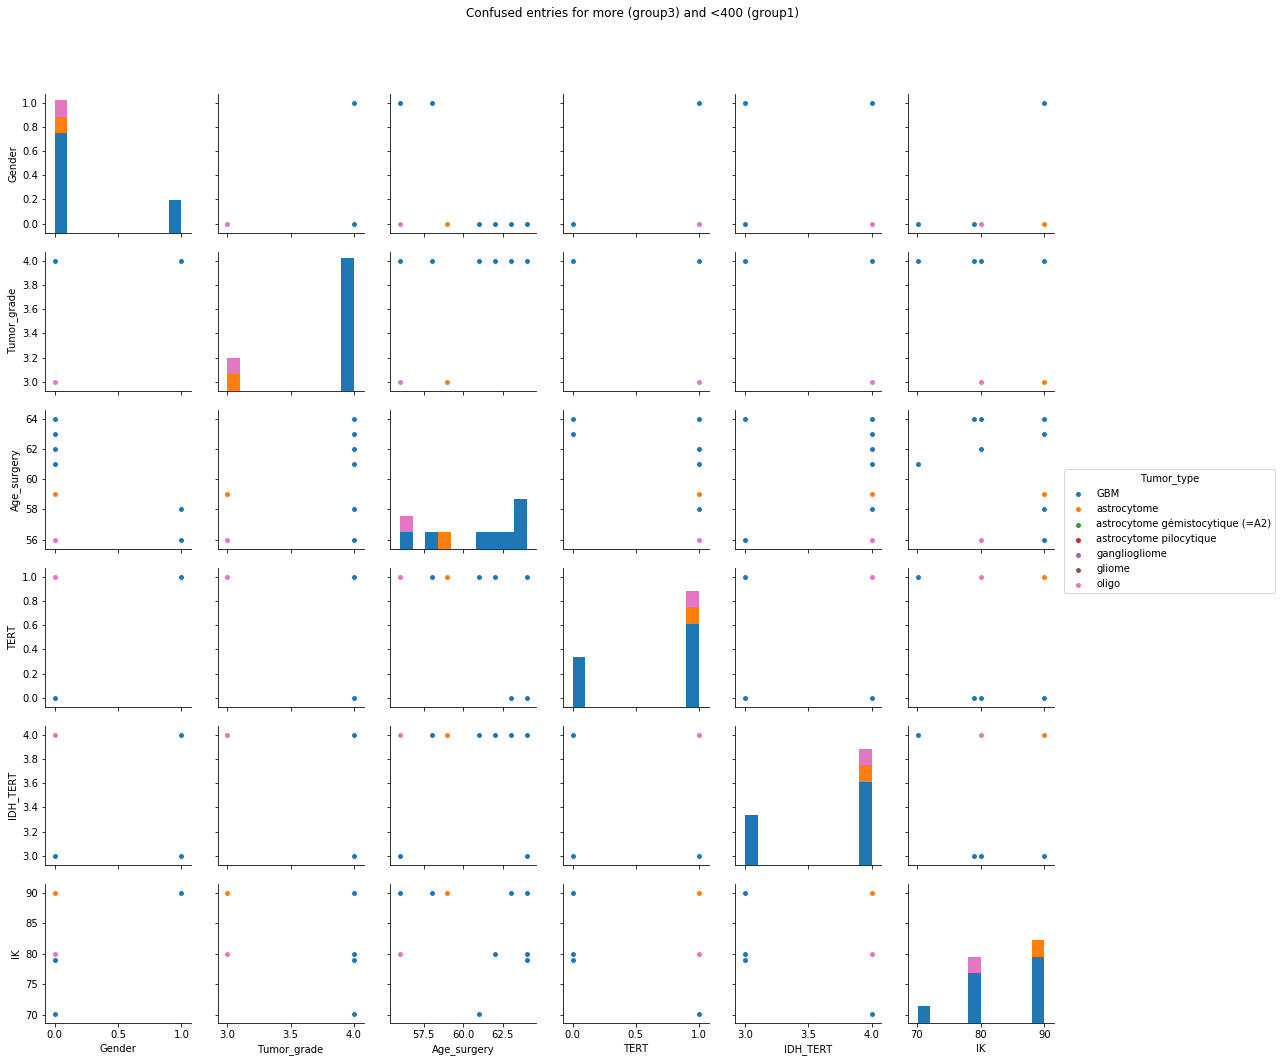

In [65]:
g5 = sns.pairplot(data=cfmore1,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g5.fig.suptitle('Confused entries for more (group3) and <400 (group1)') 
g5.savefig(results_path + "3rd-1st Group GBM confused patients")

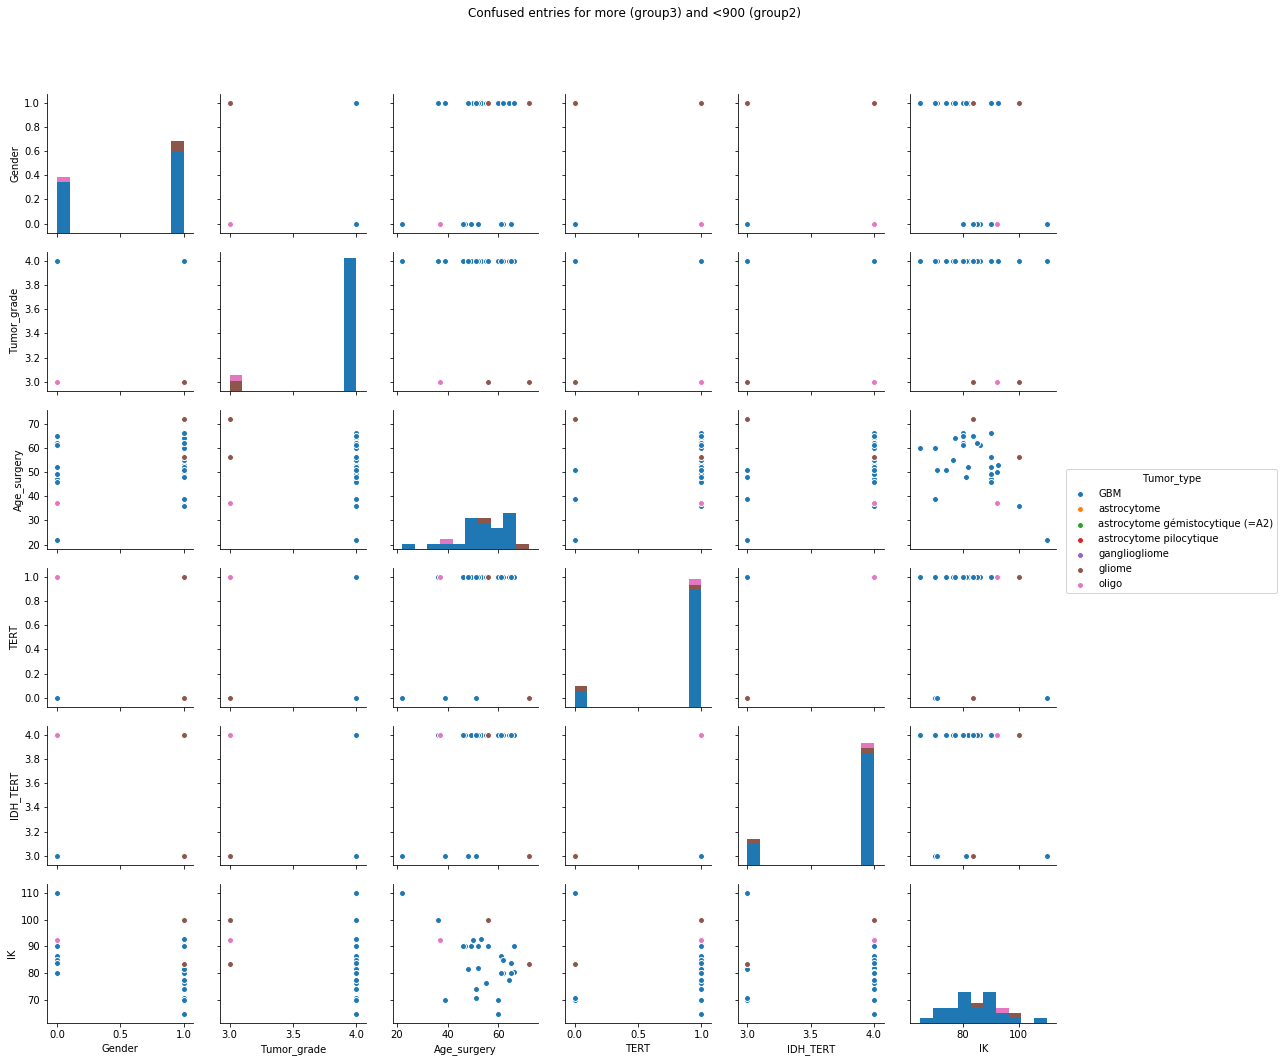

In [66]:
g6 = sns.pairplot(data=cfmore2,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g6.fig.suptitle('Confused entries for more (group3) and <900 (group2)') 
g6.savefig(results_path + "3rd-2nd Group GBM confused patients")

# XGBoost Gradient Boosting 

In [21]:
from xgboost import XGBClassifier

## Baseline XGBoost

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

    8months       0.37      0.55      0.44       119
   1.5years       0.19      0.20      0.19       133
   2.5years       0.25      0.12      0.16       116

avg / total       0.27      0.29      0.26       368

Accuracy: 0.28532608695652173


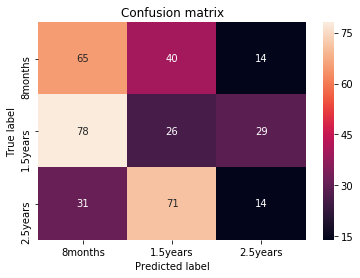

In [22]:
boost_model = XGBClassifier()
boost_model.fit(X_train, Y_train)
boost_model.score(X_test,Y_test)

probas = boost_model.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

evaluation.plot_report(Y_test, l[y_pred], labels)

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


For 3 class problem --- Accuracy: 0.42934782608695654 and Logloss: 1.3272589974272389
             precision    recall  f1-score   support

    8months       0.39      0.50      0.44       119
   1.5years       0.28      0.29      0.28       133
   2.5years       0.24      0.16      0.19       116

avg / total       0.30      0.32      0.31       368

Accuracy: 0.3179347826086957


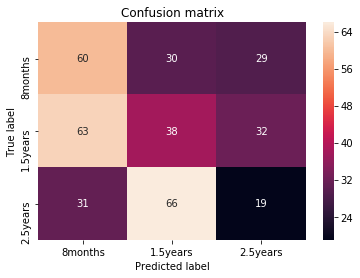

In [23]:
# Gradient Boosting classifiers based on validation/test
# What are the key aspects of tuning the XGBoost Tree
gbc = XGBClassifier(learning_rate= 0.03, 
                                 n_estimators=300,
                                 max_depth =30,                          
                                 random_state = 1123)
gbc.fit(X_train, Y_train)

# Accuracy
accuracy = gbc.score(X_test,Y_test)

# Error 
probas = gbc.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem --- Accuracy: {1} and Logloss: {2}".format(len(labels), accuracy, error))    
evaluation.plot_report(Y_test, l[y_pred], labels)

In [ ]:
#X_tr_merge = pd.concat((X_train,X_test)).as_matrix()
#Y_tr_merge = pd.concat((Y_train,Y_test)).as_matrix()

In [ ]:
#plt.figure()
#evaluation.plot_confusion_matrix(cfm, norm=True, classes=labels)
#plt.xlabel('Interpreted cluster label')
#plt.show()

In [32]:
#fig, ax = plt.subplots(1, 3, figsize=(15,10))

#ax[0].scatter(estimators_range, errors)
#ax[0].set_ylabel('Log-loss error on validation set')
#ax[0].set_xlabel('Number of estimators for Random Forest Classifier');

#ax[1].scatter(estimators_range, accuracies)
#ax[1].set_ylabel('Accuracies on validation set')
#ax[1].set_xlabel('Number of estimators for Random Forest Classifier');

#ax[2].scatter(estimators_range, roc_auc)
#ax[2].set_ylabel('AUC on validation set')
#ax[2].set_xlabel('Number of estimators for Random Forest Classifier');


## Miscellaneous - Exporting data to a tree style graph for interpretation

In [ ]:
# Feature importance in descending order
feat_order_ind = np.argsort(rf_ind.feature_importances_)[::-1] # In descending order
print('50 most important features in order of decreasing importance: \n{}'.
      format(train_A.drop(["imgId", "is_person"], axis=1).columns[feat_order_ind[0:50]]))

title = 'Learning Curves (NN with tuned hyperparameters)'    
estimator = nn01_opt # regressor with tuned hyperparameters 
plot_learning_curve(estimator, title, sine_X_train, sine_y_train, 
                    ylim=(-10., 0.), cv=5, n_jobs=-1, scoring='mean_squared_error')
plt.grid(True)
plt.show()

########### 

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names= df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
    class_names = labels,  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph
#To create a file do this:
#To create a file do this:
with open("tree.dot", 'w') as f:
     f = export_graphviz(dt, out_file=f,
                         feature_names = df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
                         class_names = labels,   
                         filled=True, rounded=True,  
                         special_characters=True)